<a href="https://colab.research.google.com/github/pravin691983/MelanomaDetectionAssignment/blob/dev/PRAVIN_TAWADE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Melanoma Detection Assignment

# Overview - Business Understanding

Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.



##  Business Objectives

To build a multiclass classification model using a custom convolutional neural network in TensorFlow.

# IMPORT LIBRARIES AND DATASETS

In [1]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
projectPath = '/content/dgdriverive/My Drive/UpGrad_AI/Workspace/Melanoma Detection Assignment/'
%cd /content/gdrive/My Drive/UpGrad_AI/Workspace/Melanoma Detection Assignment/

/content/gdrive/My Drive/UpGrad_AI/Workspace/Melanoma Detection Assignment


In [3]:
#unzip the dataset
!unzip "/content/gdrive/My Drive/UpGrad_AI/Workspace/Melanoma Detection Assignment/CNN_assignment.zip" > /dev/null

In [4]:
# import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.preprocessing.image import load_img

# Data Loading and Description

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
# Please Update the paths of the train and test dataset to run code
root_path = '/content/gdrive/My Drive/UpGrad_AI/Workspace/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

path_to_training_dataset="/content/gdrive/My Drive/UpGrad_AI/Workspace/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

## Data Description

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.


The data set contains the following diseases:

- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
-Squamous cell carcinoma
- Vascular lesion

In [6]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


# Dataset Creation

Create train & validation dataset from the train directory with a batch size of 32. Also, make sure you resize your images to 180*180.

In [7]:
batch_size = 32
img_height = 180
img_width = 180

In [8]:
# train dataset 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, 
                                                               batch_size=batch_size,
                                                               image_size=(img_height,img_width), 
                                                               label_mode='categorical',
                                                               seed=123,
                                                               subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
# validation dataset 
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                            batch_size=32,
                                                            image_size=(img_height,img_width), 
                                                            label_mode='categorical',
                                                            seed=123,
                                                            subset="validation",
                                                            validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
## Write your test dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                              image_size=(img_height, img_width),
                                                              batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [11]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Visualize the data

Create util function to visualize instances of all the nine classes present in the dataset

In [12]:
def visualizeData(input_image_dataset, input_data_dir_train):
  #all the classes of Skin Cancer
  class_names = input_image_dataset.class_names

  #Dictionary to store the path of image as per the class
  files_path_dict = {}

  for c in class_names:
      files_path_dict[c] = list(map(lambda x:str(input_data_dir_train)+'/'+c+'/'+x,os.listdir(str(input_data_dir_train)+'/'+c)))
      
  #Visualize image 
  plt.figure(figsize=(15,15))
  index = 0
  for c in class_names:
      path_list = files_path_dict[c][:1]
      index += 1
      plt.subplot(3,3,index)
      plt.imshow(load_img(path_list[0],target_size=(180,180)))
      plt.title(c)
      plt.axis("off")

Found 2239 files belonging to 9 classes.


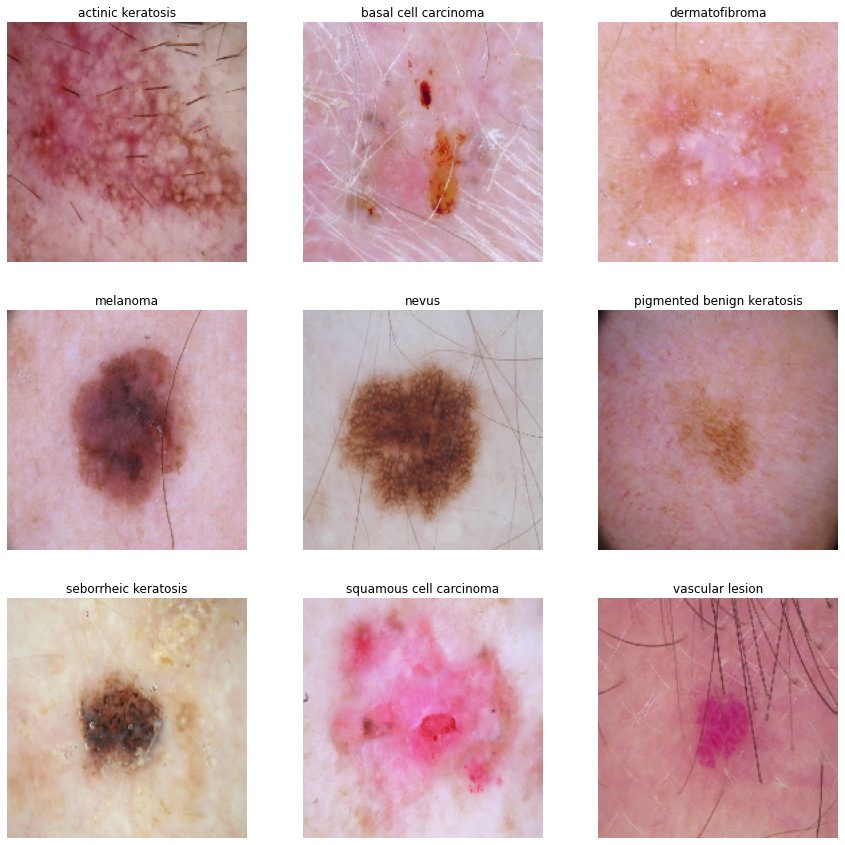

In [13]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)
visualizeData(image_dataset, data_dir_train)

Utils funcction to create a dataframe with image count and class.

In [14]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


Visualize the Number of image in each class.

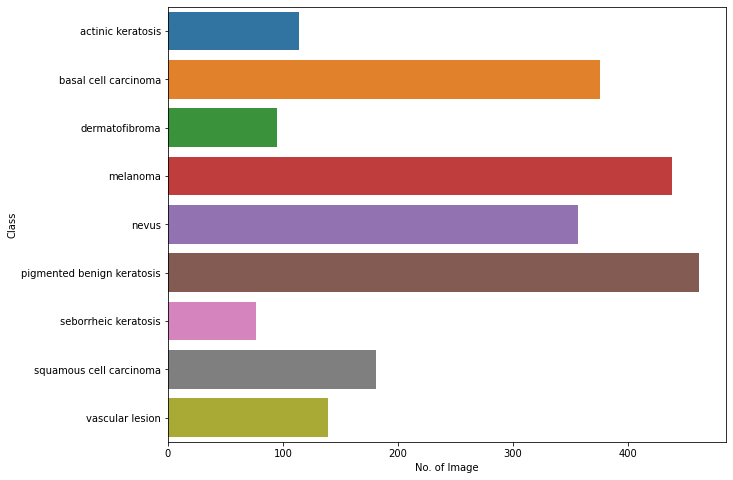

In [15]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [16]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.
#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.
#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model Building & training

- Create a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescale images to normalize pixel values between (0,1).
- Choose an appropriate optimiser and loss function for model training
- Train the model for ~20 epochs
- Write your findings after the model fit. You must check if there is any evidence of model overfit or underfit.

In [17]:
input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()

# Preprocecssing layer to rescale image
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

#First Convulation layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

#Second Convulation Layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

#Third Convulation Layer
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(Flatten())

#Dense Layer
model.add(Dense(512, activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(Dropout(0.5))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

## Number of classes is 9
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 87, 87, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0

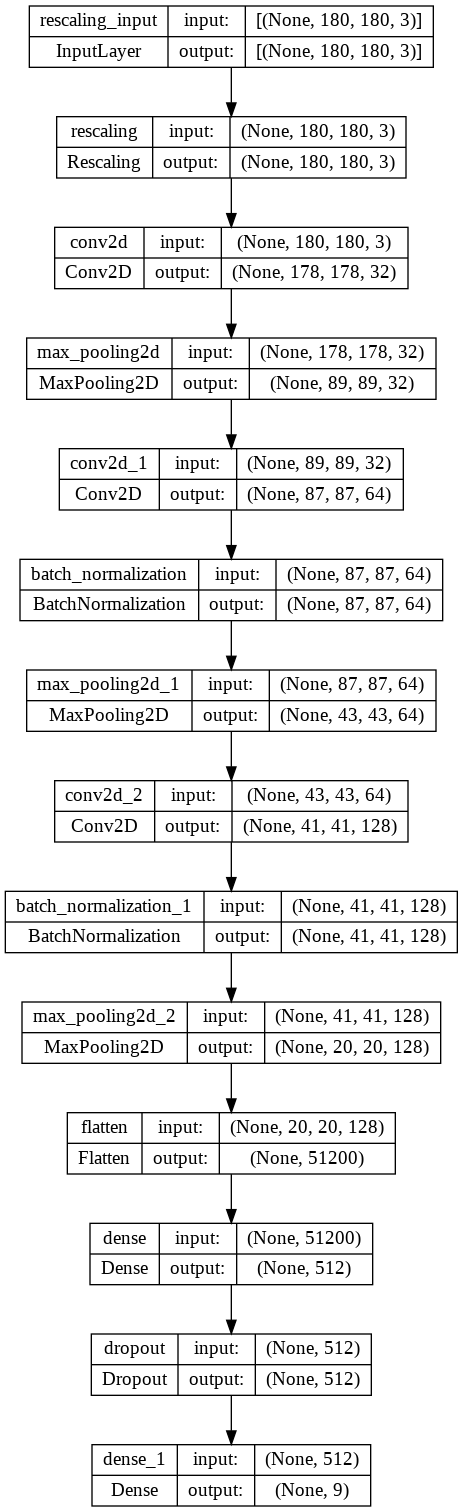

In [18]:
# vizualizing the model 
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot_1.png', show_shapes=True, show_layer_names=True)

### Compile the model

Choose an appropirate optimiser and loss function for model training

In [19]:
### Compile the Model by choose an appropirate optimiser and loss function

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model_1.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

Train the model for ~20 epochs

In [20]:
epochs = 20
batch_size = 32

# Fit the model
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[checkpoint,earlystop])

Epoch 1/20
55/56 [============================>.] - ETA: 0s - loss: 32.7147 - accuracy: 0.3045
Epoch 1: val_accuracy improved from -inf to 0.10962, saving model to model_1.h5
56/56 [==============================] - 29s 135ms/step - loss: 32.6363 - accuracy: 0.3041 - val_loss: 11.2460 - val_accuracy: 0.1096
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 16.2394 - accuracy: 0.3711
Epoch 2: val_accuracy improved from 0.10962 to 0.14989, saving model to model_1.h5
56/56 [==============================] - 4s 76ms/step - loss: 16.2394 - accuracy: 0.3711 - val_loss: 14.9183 - val_accuracy: 0.1499
Epoch 3/20
55/56 [============================>.] - ETA: 0s - loss: 5.5574 - accuracy: 0.4136
Epoch 3: val_accuracy did not improve from 0.14989
56/56 [==============================] - 3s 47ms/step - loss: 5.5093 - accuracy: 0.4124 - val_loss: 6.5757 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - ETA: 0s - loss: 2.5433 - accuracy: 0.4247
Epoch 4: val

Utils function to visualize training results

In [21]:
def visualizeResult(model_history, model_epochs_range):
  # Plot the training curves

  plt.figure(figsize=(15, 10))
  plt.subplot(1, 2, 1)

  #Plot Model Accuracy
  plt.plot(model_history.history['accuracy'])
  plt.plot(model_history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel(model_epochs_range)
  plt.legend(['train', 'val'], loc='upper left')

  #Plot Model Loss
  plt.subplot(1, 2, 2)
  plt.plot(model_history.history['loss'])
  plt.plot(model_history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel(model_epochs_range)
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

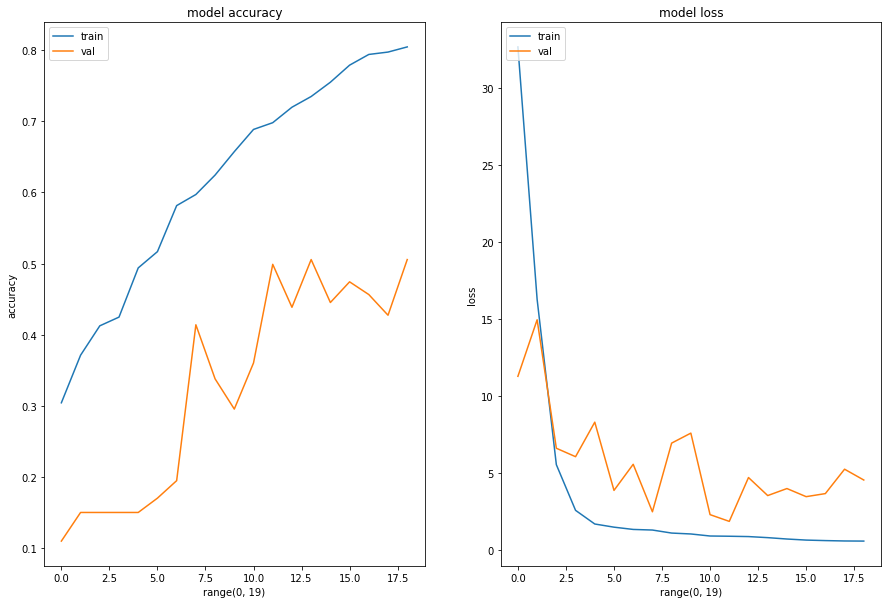

In [22]:
# Check model accuracy & loss 
epochs_range = range(earlystop.stopped_epoch+1)
visualizeResult(history, epochs_range)

Write your findings after the model fit. You must check if there is any evidence of model overfit or underfit.

In [23]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


# 

14/14 [==============================] - 0s 14ms/step - loss: 4.5126 - accuracy: 0.5056
Accuracy:  0.7371651530265808
Validation Accuracy:  0.5055928230285645
Loss:  1.3677079677581787
Validation Loss 4.512581825256348


**Thus we can clearly that model Overfit and we need to chose right data augumentation strategy**

# Model Building & training using dropout and ImageDataGenerator

In [24]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

train_batches = datagen.flow_from_directory(data_dir_train, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(data_dir_test, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)

Found 890 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


### Create the model, compile and train the model

In [25]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential()

#First Convulation layer
# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
# Adding Dropout Layer
model.add(Dropout(0.25))

#Second Convulation Layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

#Third Convulation Layer
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(Flatten())

#Dense Layer
model.add(Dense(512, activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(Dropout(0.5))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 conv2d_6 (Conv2D)           (None, 90, 90, 64)        36928     
                                                      

Compiling the model

In [26]:
#Compile the Model

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.
model.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model_2.h5",monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5, mode="auto", verbose=1)

In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

Training the model

In [27]:
## train model
epochs = 20
batch_size = 10

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

# Fit the model
history = model.fit(train_batches, validation_data=valid_batches, epochs=epochs, verbose = 1, callbacks=[learning_rate_reduction, checkpoint,earlystop])

Epoch 1/20
14/14 [==============================] - ETA: 0s - loss: 352.4941 - accuracy: 0.4011
Epoch 1: val_accuracy improved from -inf to 0.31250, saving model to model_2.h5
14/14 [==============================] - 41s 3s/step - loss: 352.4941 - accuracy: 0.4011 - val_loss: 2.1585 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 2/20
14/14 [==============================] - ETA: 0s - loss: 1.9492 - accuracy: 0.2978
Epoch 2: val_accuracy improved from 0.31250 to 0.33333, saving model to model_2.h5
14/14 [==============================] - 34s 2s/step - loss: 1.9492 - accuracy: 0.2978 - val_loss: 2.1717 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/20
14/14 [==============================] - ETA: 0s - loss: 1.1330 - accuracy: 0.4472
Epoch 3: val_accuracy did not improve from 0.33333
14/14 [==============================] - 35s 2s/step - loss: 1.1330 - accuracy: 0.4472 - val_loss: 2.1527 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 4/20
14/14 [==============================] - ETA: 0s - loss: 1.0749

Visualizing the results

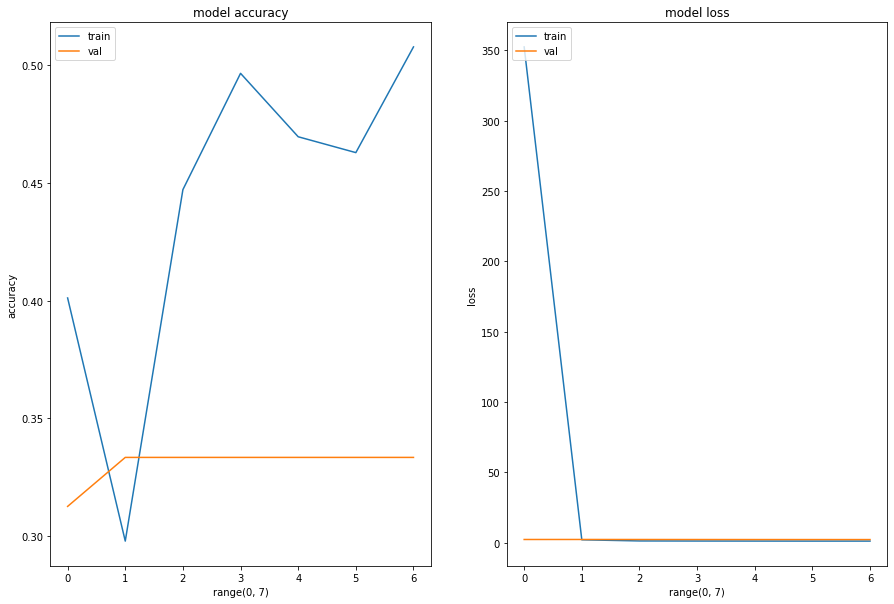

In [28]:
# Check model accuracy & loss 
epochs_range = range(earlystop.stopped_epoch+1)
visualizeResult(history, epochs_range)

In [29]:
loss, accuracy = model.evaluate(train_batches, verbose=1,)
loss_v, accuracy_v = model.evaluate(valid_batches, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

1/1 [==============================] - 4s 4s/step - loss: 2.0996 - accuracy: 0.3333
Accuracy:  0.401123583316803
Validation Accuracy:  0.3333333432674408
Loss:  2.0651097297668457
Validation Loss 2.0996038913726807


**There is some improvement now as compared to the previous model run. Let's try one attempt with an appropriate data augmentation strategy to resolve underfitting/overfitting by improving model accuracy & class imbalance**

# Model Building & training on the rectified class imbalance data using Augmentor

Rectify the class imbalance

Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.
- Which class has the least number of samples? - Actinic Keratosos and Seborrheic keratosis

- Which classes dominate the data in terms proportionate number of samples?

Pigmented benign keratosis dominates the data of count more than 100 in training

In [30]:
#install Augmentor
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use Augmentor, the following general procedure is followed:

- Instantiate a Pipeline object pointing to a directory containing your initial image data set.
- Define a number of operations to perform on this data set using your Pipeline object.
- Execute these operations by calling the Pipeline’s sample() method.

In [31]:

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/UpGrad_AI/Workspace/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F60E62416A0>: 100%|██████████| 500/500 [00:21<00:00, 23.28 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/UpGrad_AI/Workspace/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F60E629DCA0>: 100%|██████████| 500/500 [00:26<00:00, 18.75 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/UpGrad_AI/Workspace/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F60E6234F10>: 100%|██████████| 500/500 [00:18<00:00, 26.33 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/UpGrad_AI/Workspace/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F60E6304580>: 100%|██████████| 500/500 [01:23<00:00,  5.98 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/UpGrad_AI/Workspace/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F60E74F3340>: 100%|██████████| 500/500 [01:22<00:00,  6.05 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/UpGrad_AI/Workspace/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F60E70DD6A0>: 100%|██████████| 500/500 [00:18<00:00, 27.70 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/UpGrad_AI/Workspace/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F6164A94550>: 100%|██████████| 500/500 [00:43<00:00, 11.61 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/UpGrad_AI/Workspace/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6164B3BBB0>: 100%|██████████| 500/500 [00:18<00:00, 26.81 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/UpGrad_AI/Workspace/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6164B809D0>: 100%|██████████| 500/500 [00:18<00:00, 26.99 Samples/s]


In [32]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Train the model on the data created using Augmentor

In [33]:
batch_size = 32
img_height = 180
img_width = 180

Create a training dataset

In [34]:
# train dataset 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


Create a validation dataset


In [35]:
# validation dataset 
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


Create your model (make sure to include normalization)

In [36]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [37]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 41, 41, 128)      

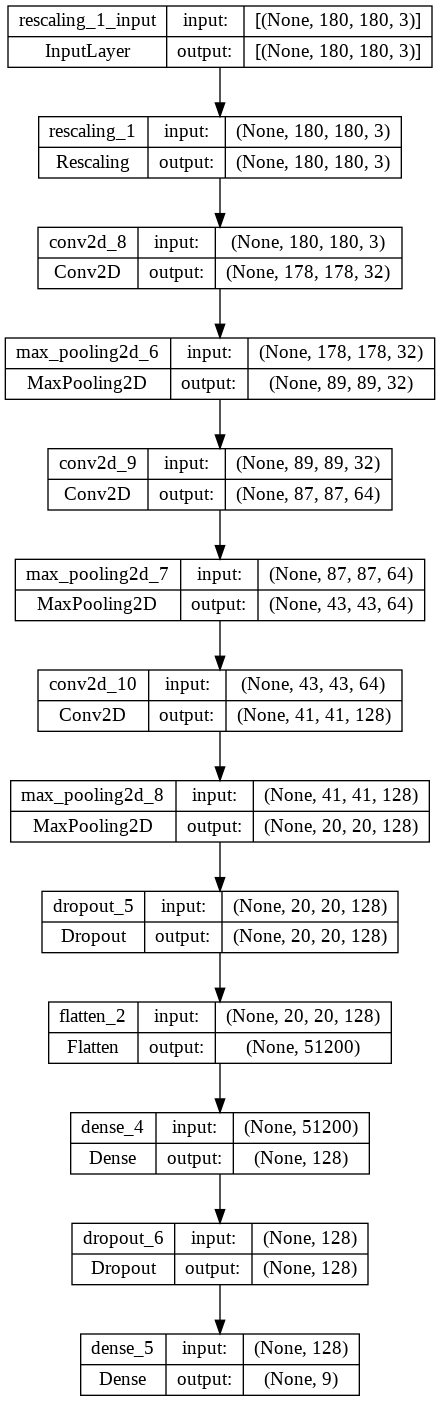

In [38]:
# vizualizing the model 
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot_3.png', show_shapes=True, show_layer_names=True)

Compile your model (Choose optimizer and loss function appropriately)

In [39]:
#Compile the Model

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model_3.h5",monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5, mode="auto", verbose=1)

Train your model

In [40]:
# Train the model
epochs = 50
batch_size = 10
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=5, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

# Fit the model
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[learning_rate_reduction, checkpoint,earlystop])

Epoch 1/50
168/169 [============================>.] - ETA: 0s - loss: 1.9119 - accuracy: 0.2599
Epoch 1: val_accuracy improved from -inf to 0.38307, saving model to model_3.h5
169/169 [==============================] - 46s 80ms/step - loss: 1.9108 - accuracy: 0.2606 - val_loss: 1.5944 - val_accuracy: 0.3831 - lr: 0.0010
Epoch 2/50
168/169 [============================>.] - ETA: 0s - loss: 1.5015 - accuracy: 0.4263
Epoch 2: val_accuracy improved from 0.38307 to 0.51819, saving model to model_3.h5
169/169 [==============================] - 7s 42ms/step - loss: 1.4999 - accuracy: 0.4266 - val_loss: 1.3040 - val_accuracy: 0.5182 - lr: 0.0010
Epoch 3/50
169/169 [==============================] - ETA: 0s - loss: 1.3505 - accuracy: 0.4896
Epoch 3: val_accuracy did not improve from 0.51819
169/169 [==============================] - 7s 40ms/step - loss: 1.3505 - accuracy: 0.4896 - val_loss: 1.2623 - val_accuracy: 0.5174 - lr: 0.0010
Epoch 4/50
169/169 [==============================] - ETA: 0s 

Visualize the model results

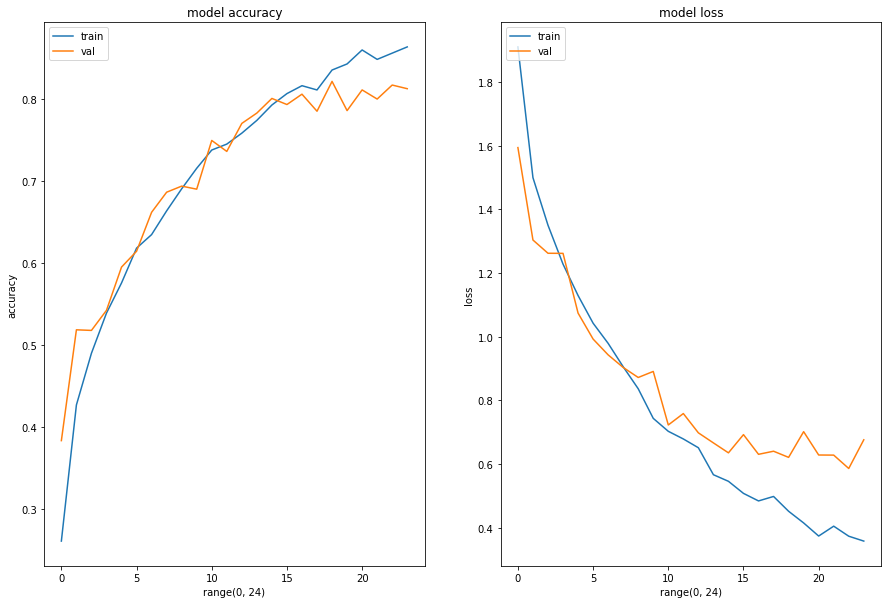

In [41]:
# Check model accuracy & loss
epochs_range = range(earlystop.stopped_epoch+1)
visualizeResult(history, epochs_range)

In [42]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

43/43 [==============================] - 1s 17ms/step - loss: 0.6761 - accuracy: 0.8122
Accuracy:  0.9350889921188354
Validation Accuracy:  0.8121752142906189
Loss:  0.18045400083065033
Validation Loss 0.676115870475769



- The class rebalance helped in reducing overfititng of the data and thus the loass is beng reduced But it reduced the Acurracy very low

- Initially we tried without the ImageDataGenerator which created data to over fit at high ratio

- Then we introduced dropout and ImageDataGenerator which reduced the over fit

**At last we tried Batch Normalization and Augumentation which really helped in carry forward.**

# Model Prediction

1/1 [==============================] - 0s 182ms/step
Actual Class : dermatofibroma
Predictive Class : basal cell carcinoma


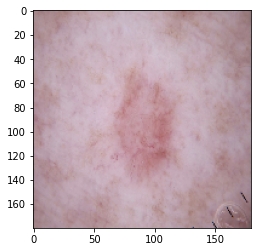

In [43]:
from glob import glob
test_class_name = 2
Test_image_path = os.path.join(data_dir_test, class_names[test_class_name], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class : "+ class_names[test_class_name] +'\n'+ "Predictive Class : "+pred_class )